
<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [LMNIST2] - Simple classification with DNN
<!-- DESC --> An example of classification using a dense neural network for the famous MNIST dataset, using PyTorch Lightning
<!-- AUTHOR : MBOGOL Touye Achille (AI/ML Engineer EFELIA-MIAI/SIMAP Lab) -->

## Objectives :
 - Recognizing handwritten numbers
 - Understanding the principle of a classifier DNN network 
 - Implementation with pytorch lightning 


The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) is a must for Deep Learning.  
It consists of 60,000 small images of handwritten numbers for learning and 10,000 for testing.


## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Create a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import lightning.pytorch as pl
import torch.nn.functional as F
import torchvision.transforms as T

import sys,os
import multiprocessing

from torchvision import datasets
from torchmetrics.functional import accuracy
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import loggers as pl_loggers
from modules.progressbar import CustomTrainProgressBar
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger

# Init Fidle environment
import fidle

run_id, run_dir, datasets_dir = fidle.init('LMNIST1')

<br>**FIDLE - Environment initialization**

Version              : 2.2b10
Run id               : MNIST1-Lightning
Run dir              : ./run/MNIST1-Lightning
Datasets dir         : /home/achille-touye/fidle-tp/datasets-fidle
Start time           : 07/11/23 10:09:31
Hostname             : achilletouye-Precision-3571 (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/MNIST1-Lightning/figs (False)
numpy                : 1.23.3
sklearn              : 1.3.2
yaml                 : 6.0.1
matplotlib           : 3.7.3
pandas               : 2.0.3
torch                : 2.1.0+cu121
torchvision          : 0.16.0+cu121
lightning            : 2.1.0


## Step 2 Retrieve data

MNIST is one of the most famous historic dataset include in torchvision Datasets. `torchvision` provides many built-in datasets in the `torchvision.datasets`.  


In [2]:
# Load data sets 
train_dataset = datasets.MNIST(root="data", train=True,  download=True, transform=None)

test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=None)

In [3]:
# print info for train data
print(train_dataset)

print()

# print info for test data
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test


In [4]:
# See the shape of train data and test data
print("x_train : ",train_dataset.data.shape)
print("y_train : ",train_dataset.targets.shape)

print()

print("x_test  : ",test_dataset.data.shape)
print("y_test  : ",test_dataset.targets.shape)

print()

# print number of labels or class
print("Number of Targets :",len(np.unique(train_dataset.targets)))
print("Targets Values :",    np.unique(train_dataset.targets))


print("\nRemark that we work with torch tensors and not numpy array, not tensorflow tensor")
print(" -> x_train.dtype = ",train_dataset.data.dtype)
print(" -> y_train.dtype = ",train_dataset.targets.dtype)

x_train :  torch.Size([60000, 28, 28])
y_train :  torch.Size([60000])

x_test  :  torch.Size([10000, 28, 28])
y_test  :  torch.Size([10000])

Number of Targets : 10
Targets Values : [0 1 2 3 4 5 6 7 8 9]

Remark that we work with torch tensors and not numpy array, not tensorflow tensor
 -> x_train.dtype =  torch.uint8
 -> y_train.dtype =  torch.int64


## Step 3 -  Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in `minibatches`, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [5]:
# Before normalization:
x_train=train_dataset.data
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

#  After normalization:
## T.Compose creates a pipeline where the provided transformations are run in sequence
transforms = T.Compose(
    [
        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        T.ToTensor()

    ]
)


train_dataset = datasets.MNIST(root="data", train=True, download=True,  transform=transforms)
test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=transforms)


# print image and label After normalization. 
## iter() followed by next() is used to get some images and label.
image,label=next(iter(train_dataset))
print('After normalization  : Min={}, max={}'.format(image.min(),image.max()))


Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


### Have a look

In [6]:
x_train=train_dataset.data
y_train=train_dataset.targets

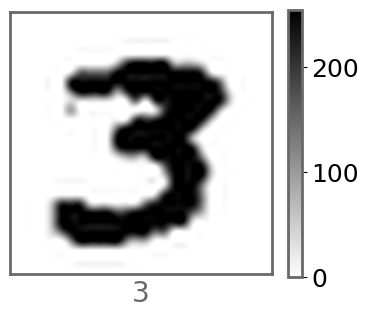

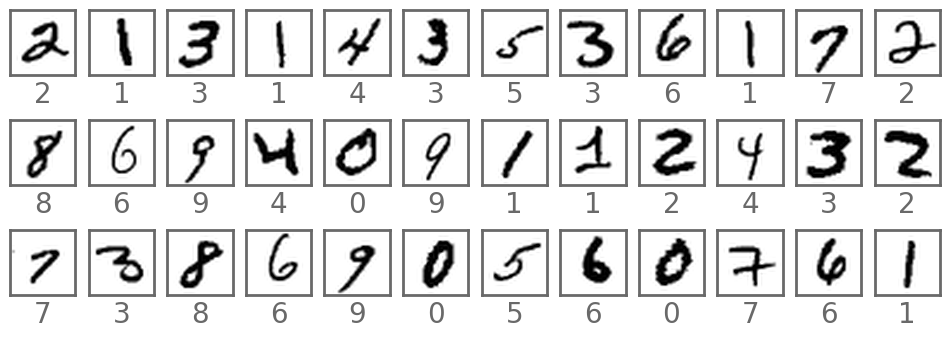

In [7]:
fidle.scrawler.images(x_train, y_train, [27],  x_size=5, y_size=5, colorbar=True, save_as='01-one-digit')
fidle.scrawler.images(x_train, y_train, range(5,41), columns=12, save_as='02-many-digits')

In [8]:
# train bacth data
train_loader= DataLoader(
  dataset=train_dataset, 
  shuffle=True, 
  batch_size=512,
  num_workers=2 
)


# test batch data
test_loader= DataLoader(
  dataset=test_dataset, 
  shuffle=False, 
  batch_size=512,
  num_workers=2  
)

# print image and label after normalization.
image, label=next(iter(train_loader))
print('Shape of first training data batch after use pytorch dataloader :\nbatch images = {} \nbatch labels = {}'.format(image.shape,label.shape))      

Shape of first training data batch after use pytorch dataloader :
batch images = torch.Size([512, 1, 28, 28]) 
batch labels = torch.Size([512])


## Step 4 - Create Model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

 `Note :` PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`) usually use for classification problem. we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. because in pytorch the cross entropy contain softmax function already.

In [9]:
class MyNet(nn.Module):
    
    def __init__(self,num_class=10):
        super().__init__()
        self.num_class = num_class
        self.model     = nn.Sequential(
            
            # Input vector:
            nn.Flatten(),                    # convert each 2D 28x28 image into a contiguous array of 784 pixel values
            
            # first hidden layer  
            nn.Linear(in_features=1*28*28, out_features=100),
            nn.ReLU(),
            nn.Dropout1d(0.1),               # Combat overfitting
            
            # second hidden layer
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(), 
            nn.Dropout1d(0.1),               # Combat overfitting
        
            # logits outpout    
            nn.Linear(100, num_class)   
        )
        

    
    # forward pass
    def forward(self, x):
        return self.model(x)



In [10]:
class LitModel(pl.LightningModule):
    
    def __init__(self, MyNet):
        super().__init__()
        self.MyNet = MyNet
        
    # forward pass
    def forward(self, x):                                                             
        return self.MyNet(x)


    def configure_optimizers(self):
        # optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer    
    
     
    def training_step(self, batch, batch_idx):
        # defines the train loop
        x, y  = batch
        
        # forward pass
        y_hat = self.MyNet(x)                                                         

        # computes the cross entropy loss between input logits and target
        loss  = F.cross_entropy(y_hat, y)    
        
        # accuracy metrics  
        acc   = accuracy(y_hat, y,task="multiclass",num_classes=10)                  

        metrics = {"train_loss": loss, 
                   "train_acc" : acc
                  }
        
        # logs metrics for each training_step
        self.log_dict(metrics,
                      on_step  = False,
                      on_epoch = True, 
                      prog_bar = True, 
                      logger   = True
                     ) 
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        #  defines the valid loop.
        x, y  = batch

        # forward pass
        y_hat = self.MyNet(x)                                                         
        
        # computes the cross entropy loss between input logits and target
        loss  = F.cross_entropy(y_hat, y)
        
        # accuracy metrics
        acc   = accuracy(y_hat, y,task="multiclass",num_classes=10)                  
        
        metrics = {"test_loss": loss, 
                   "test_acc": acc
                  }
        
        # logs metrics for each validation_step
        self.log_dict(metrics,
                      on_step  = False,
                      on_epoch = True, 
                      prog_bar = True, 
                      logger   = True
                     )
        
        return metrics
    
    
    def predict_step(self, batch, batch_idx):
        # defnie the predict loop 
        x, y  = batch
        
        # forward pass
        y_hat = self.MyNet(x) 
        
        return y_hat
    

In [11]:
# print summary model
model=LitModel(MyNet())
print(model) 

LitModel(
  (MyNet): MyNet(
    (model): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=100, bias=True)
      (2): ReLU()
      (3): Dropout1d(p=0.1, inplace=False)
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
      (6): Dropout1d(p=0.1, inplace=False)
      (7): Linear(in_features=100, out_features=10, bias=True)
    )
  )
)


## Step 5 - Train Model

In [12]:
# loggers data
logger= TensorBoardLogger(save_dir='MNIST2_logs',name="DNN_logs")

In [13]:
# train model
trainer= pl.Trainer(accelerator='auto',
                    max_epochs=20,
                    logger=logger,
                    num_sanity_val_steps=0,
                    callbacks=[CustomTrainProgressBar()]
                   )

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader)

0it [00:00, ?it/s]
0it [00:00, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-11-07 10:09:36.517758: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 10:09:36.518895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 10:09:36.542733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 10:09:41.636494: W tensorflow/compiler/tf2tensorr

Epoch 19: 100%|████████| 118/118 [00:01<00:00, 103.43it/s, v_num=4, test_loss=0.0765, test_acc=0.977, train_loss=0.459, train_acc=0.826]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████| 118/118 [00:01<00:00, 102.88it/s, v_num=4, test_loss=0.0765, test_acc=0.977, train_loss=0.459, train_acc=0.826]


## Step 6 - Evaluate
### 6.1 - Final loss and accuracy

In [14]:
score=trainer.validate(model=model,dataloaders=test_loader, verbose=False)

print('x_test / acc      : {:5.4f}'.format(score[0]['test_acc']))
print('x_test / loss     : {:5.4f}'.format(score[0]['test_loss']))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


x_test / acc      : 0.9768
x_test / loss     : 0.0765


## 6.2 - Plot history

In [15]:
# launch Tensorboard 
%reload_ext tensorboard
%tensorboard --logdir=MNIST2_logs/DNN_logs/ --bind_all

###  6.3 - Plot results

In [16]:
# logits outpout by batch size
y_logits=trainer.predict(model=model,dataloaders=test_loader)

# Concat into single tensor
y_logits=torch.cat(y_logits)

# output probabilities values
y_pred_values=F.softmax(y_logits,dim=1)

# Returns the indices of the maximum output probabilities values 
y_pred=torch.argmax(y_pred_values,dim=-1).numpy()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [17]:
x_test=test_dataset.data
y_test=test_dataset.targets

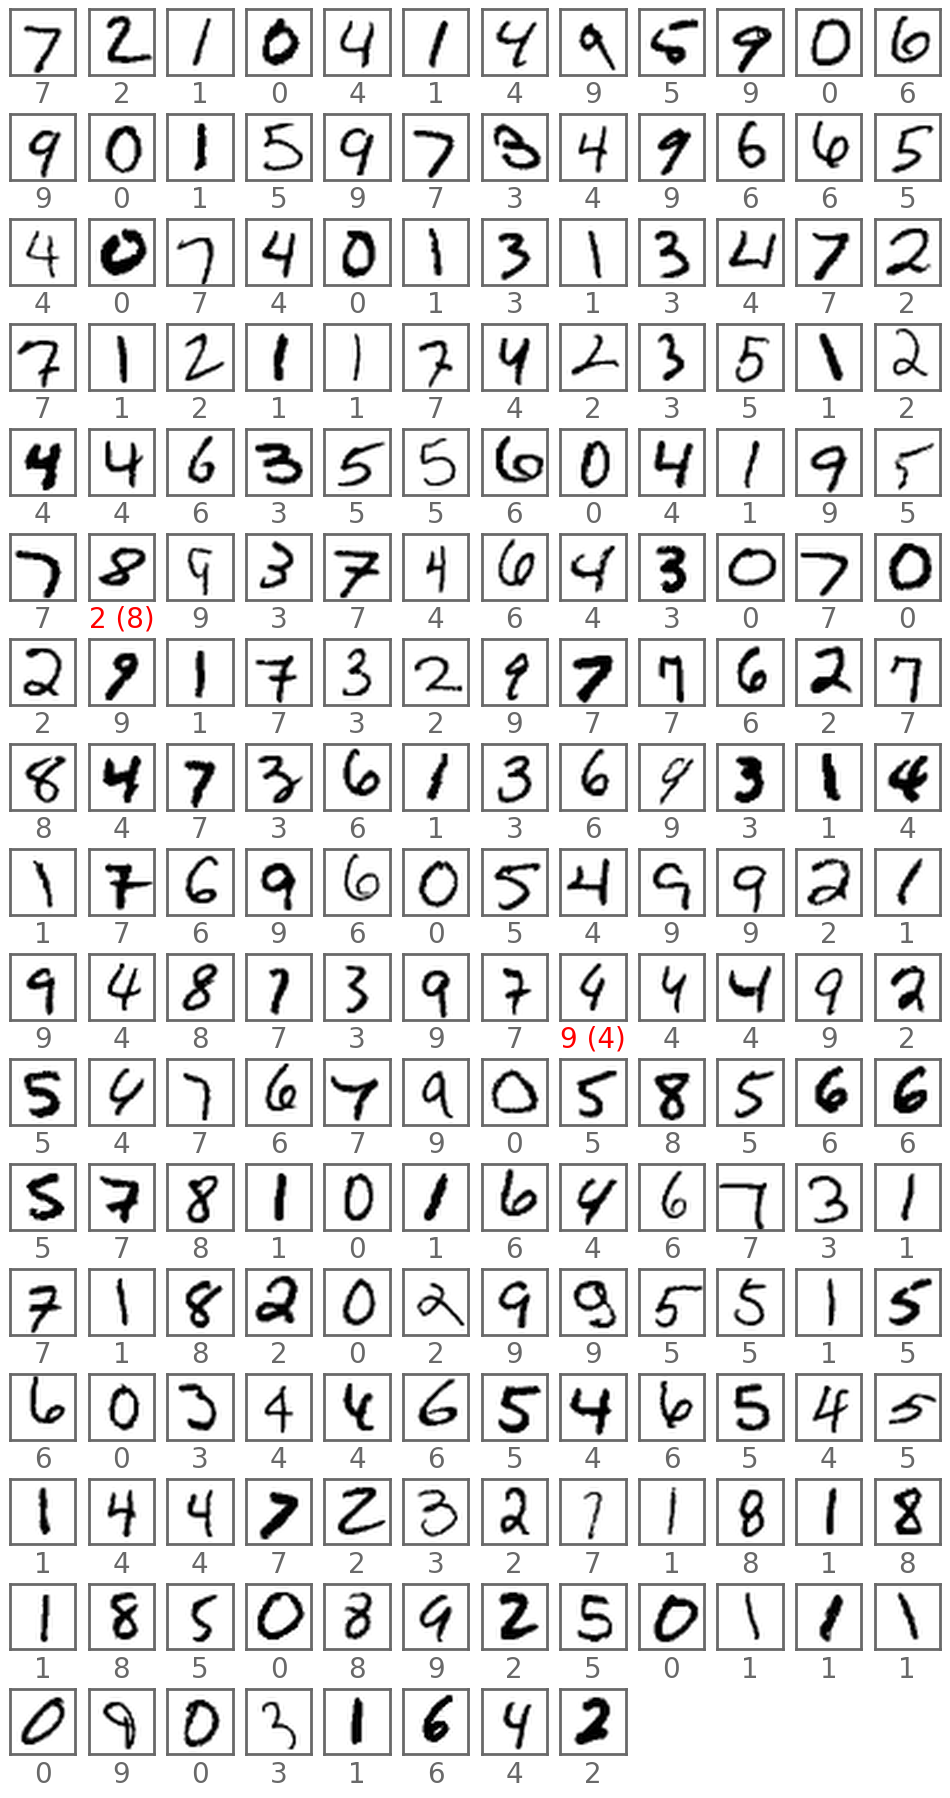

In [18]:
fidle.scrawler.images(x_test, y_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=y_pred, save_as='04-predictions')

### 6.4 - Plot some errors

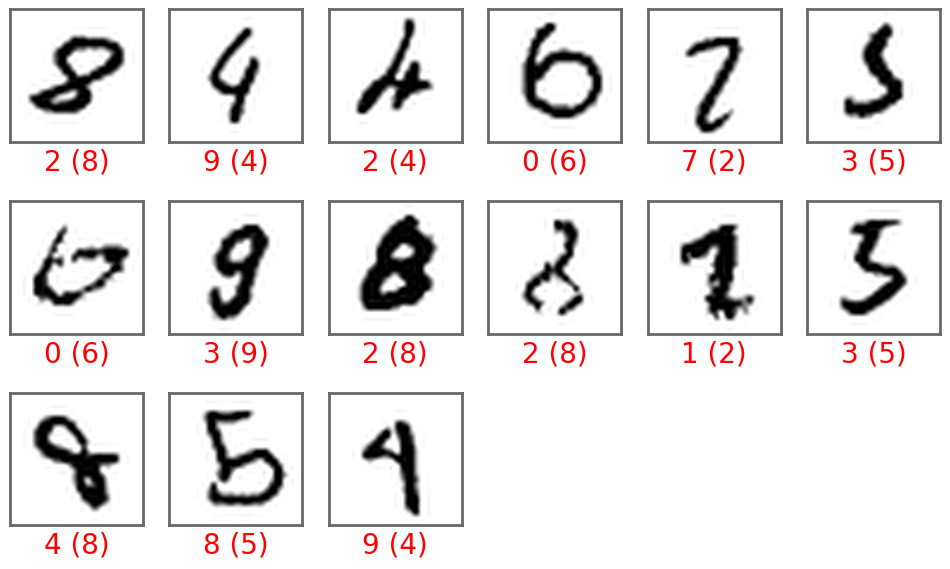

In [19]:
errors=[ i for i in range(len(x_test)) if y_pred[i]!=y_test[i] ]
errors=errors[:min(24,len(errors))]
fidle.scrawler.images(x_test, y_test, errors[:15], columns=6, x_size=2, y_size=2, y_pred=y_pred, save_as='05-some-errors')

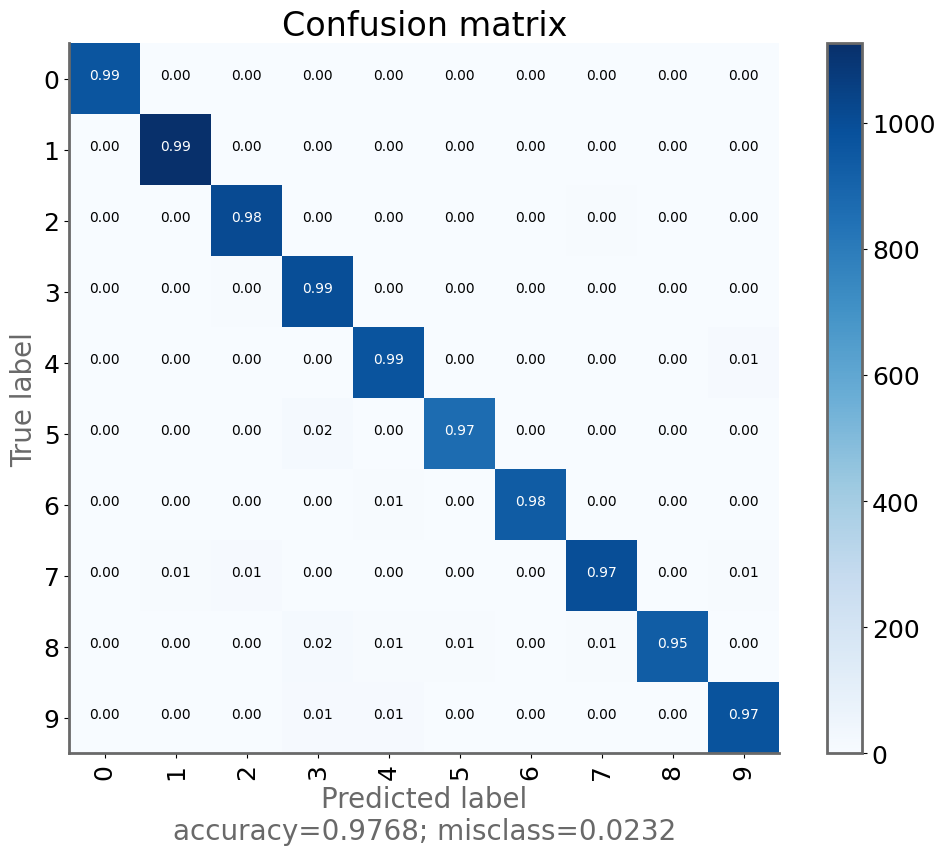

In [20]:
fidle.scrawler.confusion_matrix(y_test,y_pred,range(10),normalize=True, save_as='06-confusion-matrix')

In [21]:
fidle.end()

**End time :** 07/11/23 10:10:50  
**Duration :** 00:01:19 097ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

<div class="todo">
    A few things you can do for fun:
    <ul>
        <li>Changing the network architecture (layers, number of neurons, etc.)</li>
        <li>Display a summary of the network</li>
        <li>Retrieve and display the softmax output of the network, to evaluate its "doubts".</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>